In [3]:
pip install psycopg2

In [40]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import psycopg2
import traceback
import sqlalchemy as sqla
import matplotlib.pyplot as plt
import numpy as np
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn

# Function that performs one iteration of gradient descent to improve the model parameters:
def train_loop(net,loss_fn,optimizer,X_train,Y_train):
    pred = net(X_train) # this calls the net.forward function, returning one prediction for each row of X.
    loss = loss_fn(pred, Y_train) # compute the loss associated with the predictions
    loss_traj.append(loss) # Record the loss at each iteration

    # Gradient descent
    optimizer.zero_grad() # Reset the gradients to zero
    loss.backward() # Compute the gradient of the loss with respect to each weight in the network
    optimizer.step() # Take a gradient step


df = pd.read_csv('load_per_country.csv', parse_dates=['DateTime'], index_col = ['DateTime'])
select = df[['PL','DE']]

select_2012 = select.loc['2012-01-01':'2015-12-31']


nonan = select_2012.dropna()
nonan = nonan.groupby(pd.Grouper(level='DateTime', axis=0, freq='24H')).sum()
print(nonan)

nonan = nonan / nonan.max(axis=0)

x_train, x_test, y_train, y_test = train_test_split(nonan.iloc[:, 1:].values, nonan['PL'].values,test_size=0.2)

                  PL         DE
DateTime                       
2012-01-01  322427.0   953331.0
2012-01-02  411893.0  1259040.0
2012-01-03  433851.0  1335540.0
2012-01-04  440509.0  1345656.0
2012-01-05  442268.0  1376762.0
...              ...        ...
2015-12-27  328159.0  1067776.0
2015-12-28  400402.0  1215866.0
2015-12-29  416257.0  1234045.0
2015-12-30  422671.0  1237287.0
2015-12-31  387856.0  1158909.0

[1461 rows x 2 columns]


In [41]:
print(nonan.values)
print(nonan.iloc[:, 1:].values)
print(nonan.iloc[:, :1].values)
#x_train, x_test, y_train, y_test = train_test_split(nonan.iloc[:, 1:].values, nonan['PL'].values,test_size=0.2)

[[0.64393189 0.57451382]
 [0.82260803 0.75874579]
 [0.86646123 0.80484762]
 ...
 [0.83132354 0.74368284]
 [0.8441332  0.7456366 ]
 [0.77460277 0.69840301]]
[[0.57451382]
 [0.75874579]
 [0.80484762]
 ...
 [0.74368284]
 [0.7456366 ]
 [0.69840301]]
[[0.64393189]
 [0.82260803]
 [0.86646123]
 ...
 [0.83132354]
 [0.8441332 ]
 [0.77460277]]


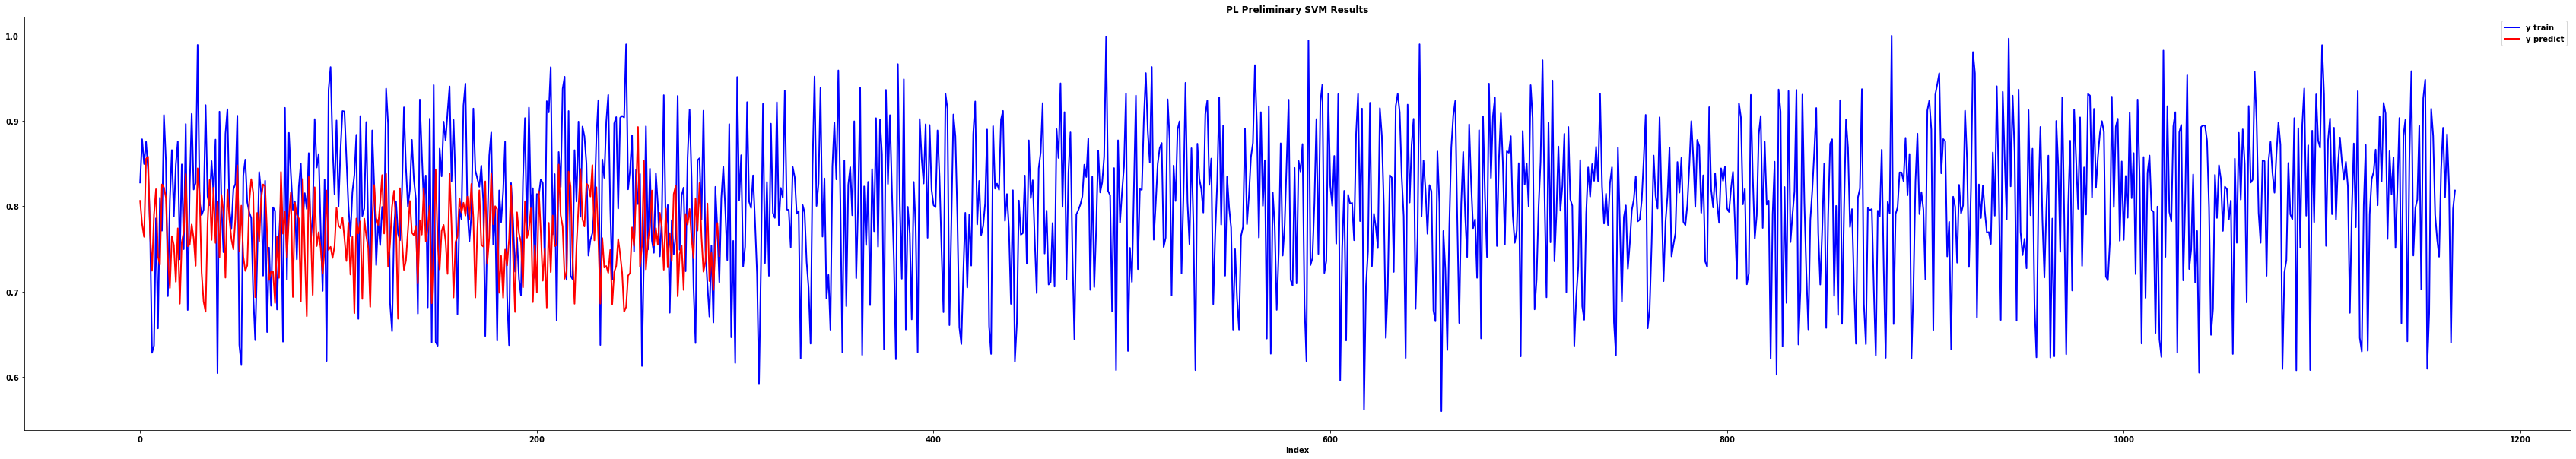

In [42]:
x_train, x_test, y_train, y_test = train_test_split(nonan.iloc[:, :1].values, nonan['PL'].values,test_size=0.2)

svr = SVR(kernel="poly").fit(x_train, y_train)
y_train_predict=svr.predict(x_test)

plt.plot( y_train, lw=2, color="blue", label="y train")
plt.plot( y_train_predict, lw=2, color="red", label="y predict")
plt.legend()
plt.title("PL Preliminary SVM Results")
plt.xlabel("Index")
plt.rcParams["figure.figsize"] = (60,10)
plt.show()

In [43]:
def plot_points(X, y):
    admitted = X[np.argwhere(y==1)]
    rejected = X[np.argwhere(y==0)]
    plt.scatter([s[0][0] for s in rejected], [s[0][1] for s in rejected], s = 25, color = 'blue', edgecolor = 'k')
    plt.scatter([s[0][0] for s in admitted], [s[0][1] for s in admitted], s = 25, color = 'red', edgecolor = 'k')

def display(m, b, color='g--'):
    plt.xlim(-0.05,1.05)
    plt.ylim(-0.05,1.05)
    x = np.arange(-10, 10, 0.1)
    plt.plot(x, m*x+b, color)

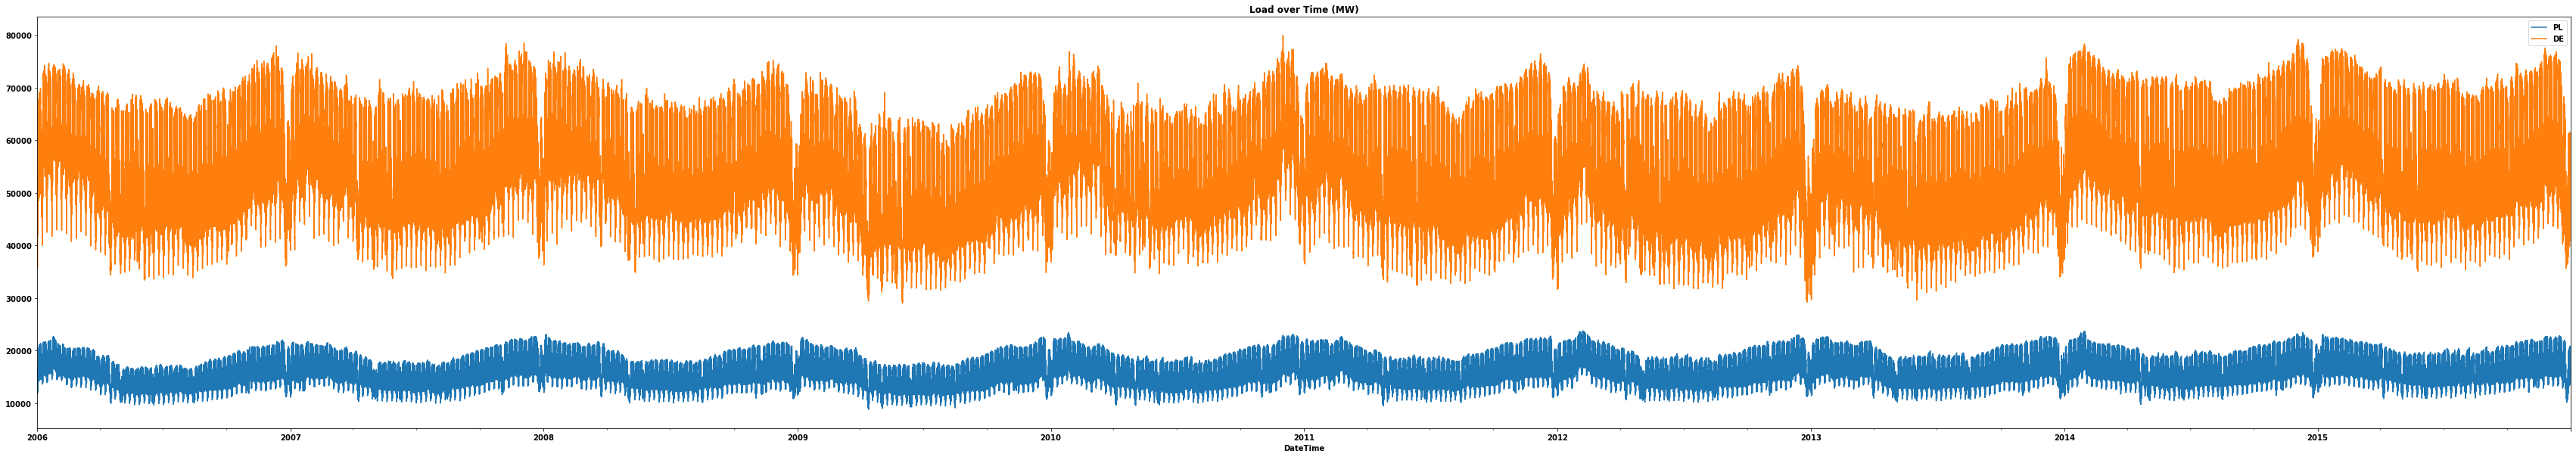

In [44]:
select.plot()
plt.legend()
plt.title("Load over Time (MW)")
plt.show()

In [45]:
x_train, x_test, y_train, y_test = train_test_split(nonan.iloc[:, :1].values, nonan['PL'].values,test_size=0.795)

X_train_torch = torch.tensor(x_train).float()
Y_train_torch = torch.tensor(y_train).float()
X_test_torch = torch.tensor(x_test).float()
Y_test_torch = torch.tensor(y_test).float()
nbus = 299

In [46]:
len(y_train)

299

In [47]:
len(y_test)

1162

In [48]:
def train_loop(net,loss_fn,optimizer,X_train,Y_train):
    pred = net(X_train) # this calls the net.forward function, returning one prediction for each row of X.
    loss = loss_fn(pred, Y_train) # compute the loss associated with the predictions
    loss_traj.append(loss) # Record the loss at each iteration

    # Gradient descent
    optimizer.zero_grad() # Reset the gradients to zero
    loss.backward() # Compute the gradient of the loss with respect to each weight in the network
    optimizer.step() # Take a gradient step


class state_net(nn.Module): 
    def __init__(self):
        super(state_net, self).__init__()
        n_hidden = 299
        self.model = nn.Sequential(
            nn.Linear(nbus,n_hidden),
            nn.ReLU(),
            nn.Linear(n_hidden,n_hidden),
            nn.ReLU(),
            nn.Linear(n_hidden,n_hidden),
            nn.ReLU(),
            nn.Linear(n_hidden,nbus),
        )

    def forward(self, x): 
        return self.model(x)

C:\Python\lib\site-packages\torch\nn\modules\loss.py:529: UserWarning: Using a target size (torch.Size([299])) that is different to the input size (torch.Size([1, 299])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Training error:  8.673848725757754e-16


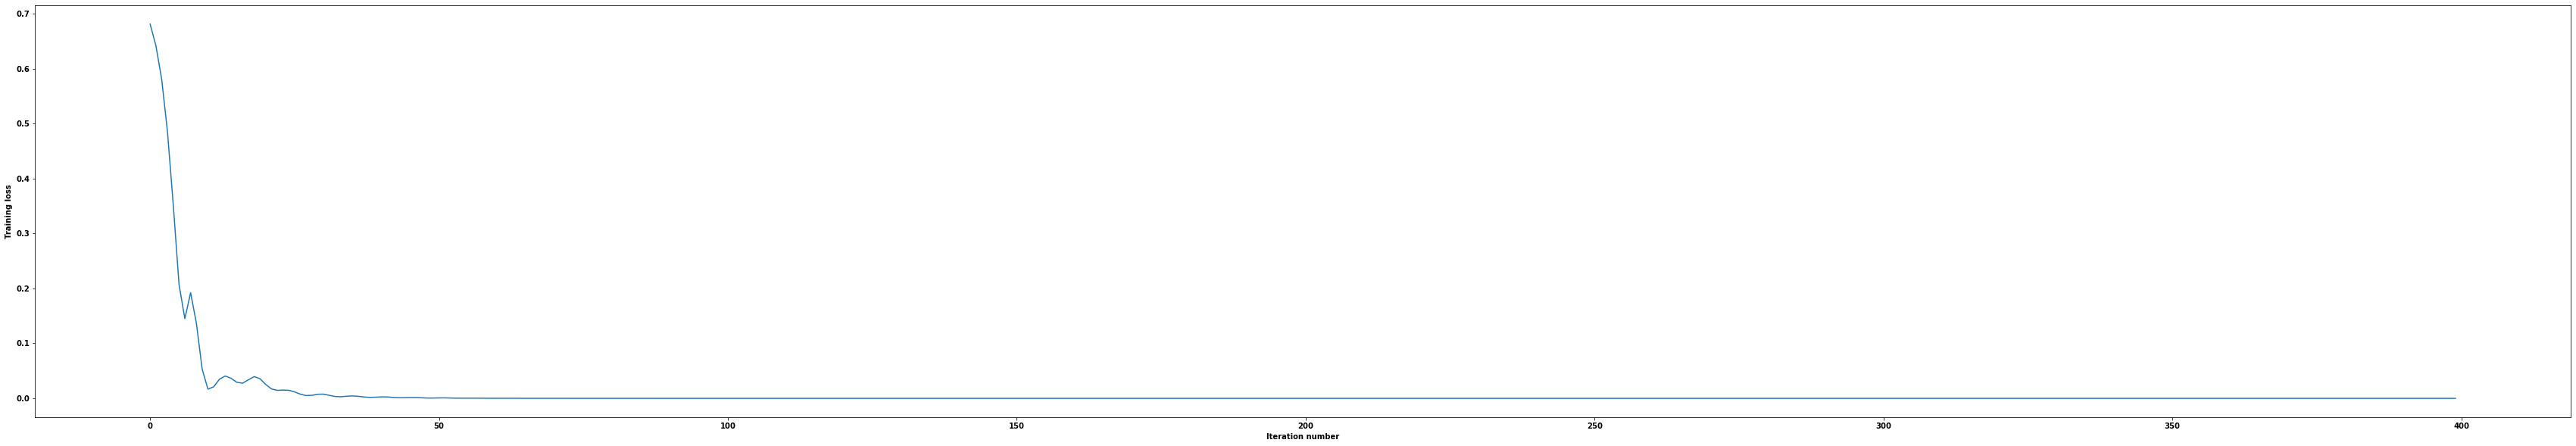

In [49]:
# Loss function for training:
loss_fn = nn.MSELoss()

net = state_net() # Create neural network

# Create an 'optimizer' object for training:
learning_rate = 1e-3
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)

loss_traj = []
    
T = 400
for t in range(T):
    train_loop(net,loss_fn,optimizer,X_train_torch.T,Y_train_torch)
    
Y_hat_train = net(X_train_torch.T)
#Y_hat_test = net(X_test_torch.T)
print("Training error: ", (torch.linalg.norm(Y_hat_train-Y_train_torch,ord='fro')**2/len(x_train)).item())
#print("Test error: ", (torch.linalg.norm(Y_hat_test-Y_test_torch,ord='fro')**2/(M-n)).item())
loss_traj2 = []
for i in range(len(loss_traj)):
    #print(loss_traj[i])
    a = loss_traj[i].detach()
    loss_traj2.append(a)
plt.plot(loss_traj2)
#plt.plot(loss_traj)
plt.xlabel('Iteration number')
plt.ylabel('Training loss');

In [50]:
y_pred = []
for i in range(len(Y_hat_train)):
    #print(loss_traj[i])
    a = Y_hat_train[i].detach()
    y_pred.append(a)

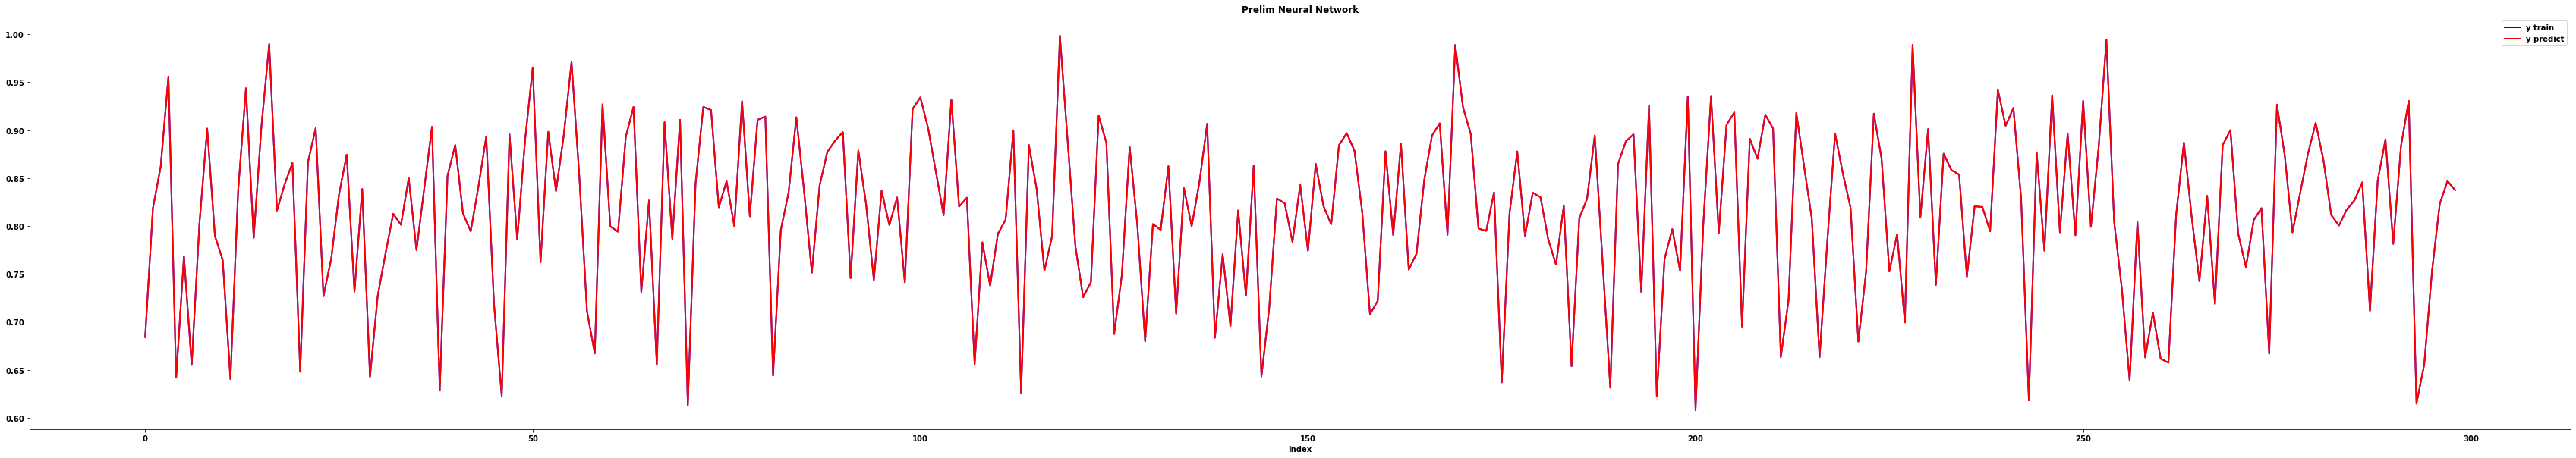

In [51]:
plt.plot( Y_train_torch, lw=2, color="blue", label="y train")
plt.plot( y_pred[0], lw=2, color="red", label="y predict")
plt.legend()
plt.title("Prelim Neural Network")
plt.xlabel("Index")
plt.rcParams["figure.figsize"] = (60,10)
plt.show()

C:\Python\lib\site-packages\torch\nn\modules\loss.py:529: UserWarning: Using a target size (torch.Size([299])) that is different to the input size (torch.Size([1, 299])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Training error:  3.3269556814347068e-15


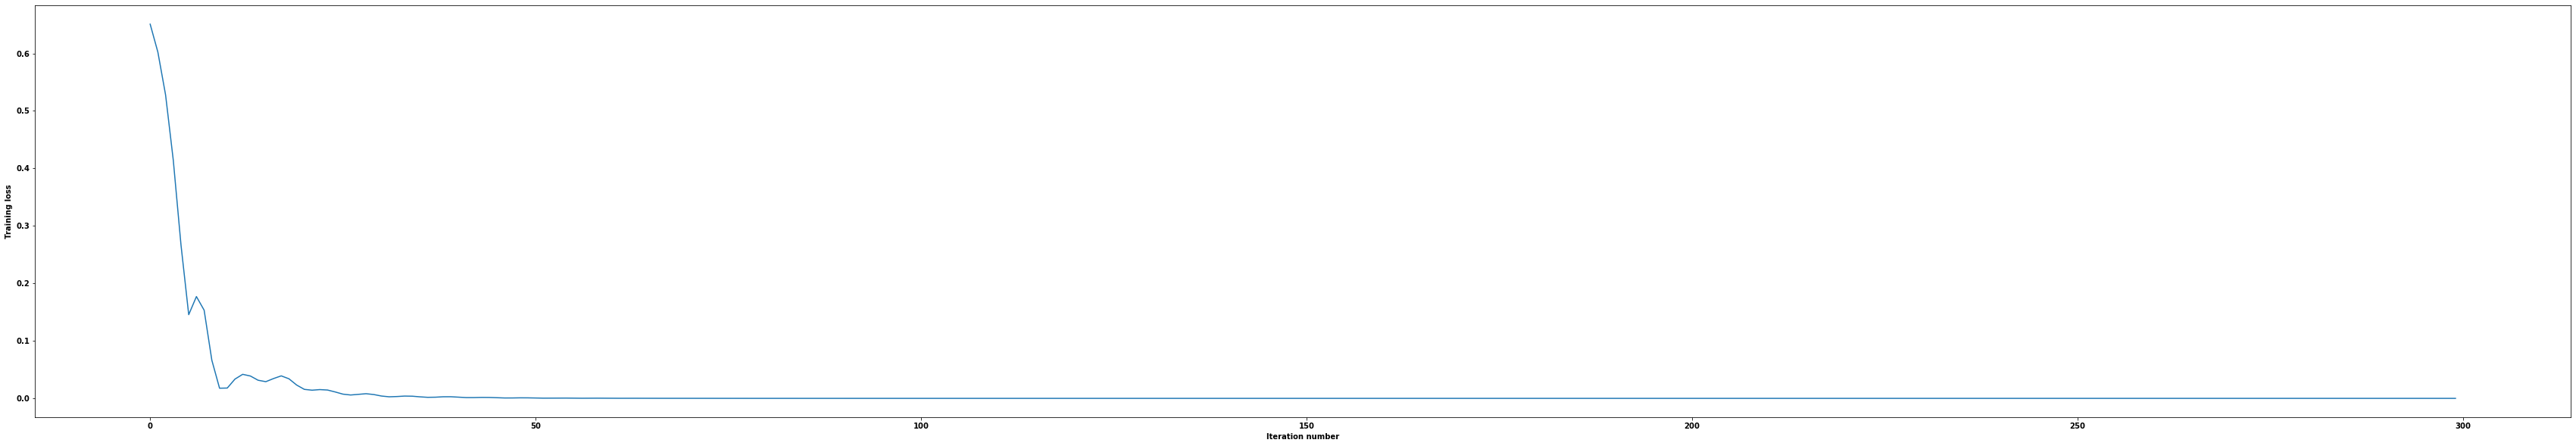

In [52]:
nonan = nonan / nonan.max(axis=0)

x_trainDE, x_testDE, y_trainDE, y_testDE = train_test_split(nonan.iloc[:, :1].values, nonan['DE'].values,test_size=0.795)

X_train_torchDE = torch.tensor(x_trainDE).float()
Y_train_torchDE = torch.tensor(y_trainDE).float()
X_test_torchDE = torch.tensor(x_testDE).float()
Y_test_torchDE = torch.tensor(y_testDE).float()


nbus = 299
def train_loop(net,loss_fn,optimizer,X_train,Y_train):
    pred = net(X_train) # this calls the net.forward function, returning one prediction for each row of X.
    loss = loss_fn(pred, Y_train) # compute the loss associated with the predictions
    loss_traj.append(loss) # Record the loss at each iteration

    # Gradient descent
    optimizer.zero_grad() # Reset the gradients to zero
    loss.backward() # Compute the gradient of the loss with respect to each weight in the network
    optimizer.step() # Take a gradient step


class state_net(nn.Module): 
    def __init__(self):
        super(state_net, self).__init__()
        n_hidden = 299
        self.model = nn.Sequential(
            nn.Linear(nbus,n_hidden),
            nn.ReLU(),
            nn.Linear(n_hidden,n_hidden),
            nn.ReLU(),
            nn.Linear(n_hidden,n_hidden),
            nn.ReLU(),
            nn.Linear(n_hidden,nbus),
        )

    def forward(self, x): 
        return self.model(x)

loss_fn = nn.MSELoss()

net = state_net() # Create neural network

# Create an 'optimizer' object for training:
learning_rate = 1e-3
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)

loss_traj = []
    
T = 300
for t in range(T):
    train_loop(net,loss_fn,optimizer,X_train_torchDE.T,Y_train_torchDE)

Y_hat_trainDE = net(X_train_torchDE.T)
#Y_hat_test = net(X_test_torch.T)
print("Training error: ", (torch.linalg.norm(Y_hat_trainDE-Y_train_torchDE,ord='fro')**2/len(x_trainDE)).item())
#print("Test error: ", (torch.linalg.norm(Y_hat_test-Y_test_torch,ord='fro')**2/(M-n)).item())
loss_traj2 = []
for i in range(len(loss_traj)):
    #print(loss_traj[i])
    a = loss_traj[i].detach()
    loss_traj2.append(a)
plt.plot(loss_traj2)
#plt.plot(loss_traj)
plt.xlabel('Iteration number')
plt.ylabel('Training loss');

y_predDE = []
for i in range(len(Y_hat_trainDE)):
    #print(loss_traj[i])
    a = Y_hat_trainDE[i].detach()
    y_predDE.append(a)


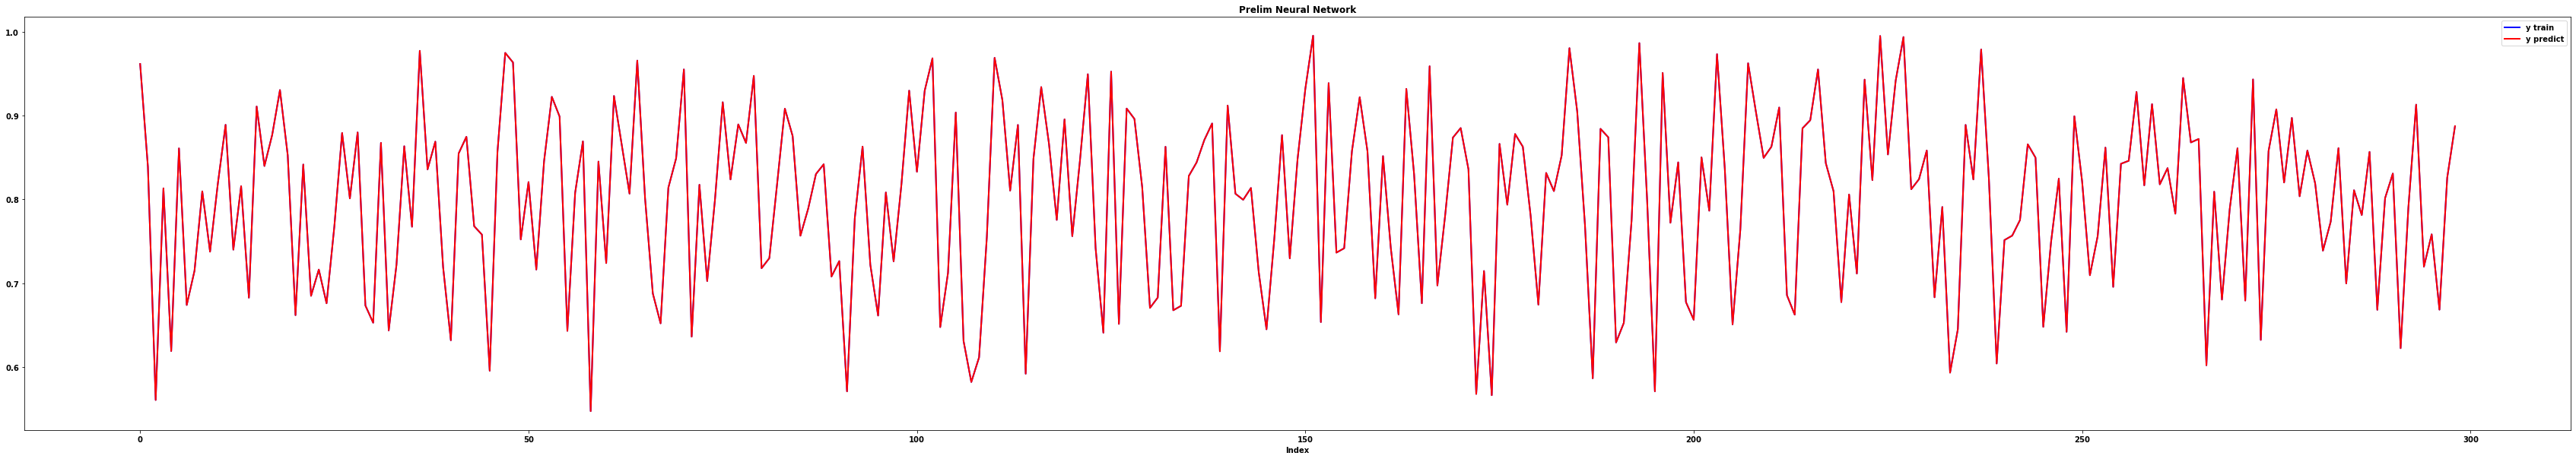

In [53]:
plt.plot( Y_train_torchDE, lw=2, color="blue", label="y train")
plt.plot( y_predDE[0], lw=2, color="red", label="y predict")
plt.legend()
plt.title("Prelim Neural Network")
plt.xlabel("Index")
plt.rcParams["figure.figsize"] = (60,10)
plt.show()

Training error:  3.3269556814347068e-15


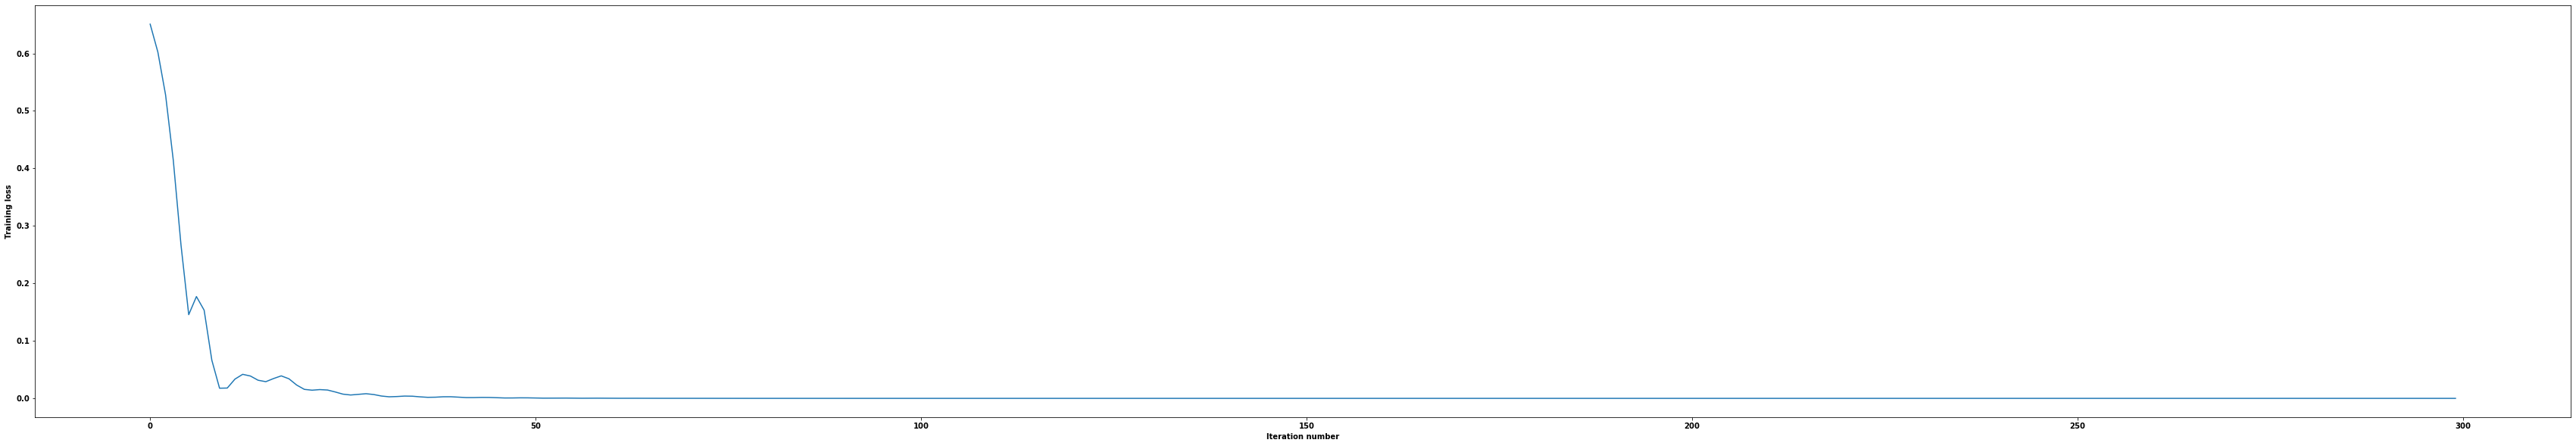

In [62]:
print("Training error: ", (torch.linalg.norm(Y_hat_trainDE-Y_train_torchDE,ord='fro')**2/len(x_train)).item())
#print("Test error: ", (torch.linalg.norm(Y_hat_test-Y_test_torch,ord='fro')**2/(M-n)).item())
loss_traj2 = []
for i in range(len(loss_traj)):
    #print(loss_traj[i])
    a = loss_traj[i].detach()
    loss_traj2.append(a)
plt.plot(loss_traj2)
#plt.plot(loss_traj)
plt.xlabel('Iteration number')
plt.ylabel('Training loss');

y_pred = []
for i in range(len(Y_hat_trainDE)):
    #print(loss_traj[i])
    a = Y_hat_trainDE[i].detach()
    y_pred.append(a)

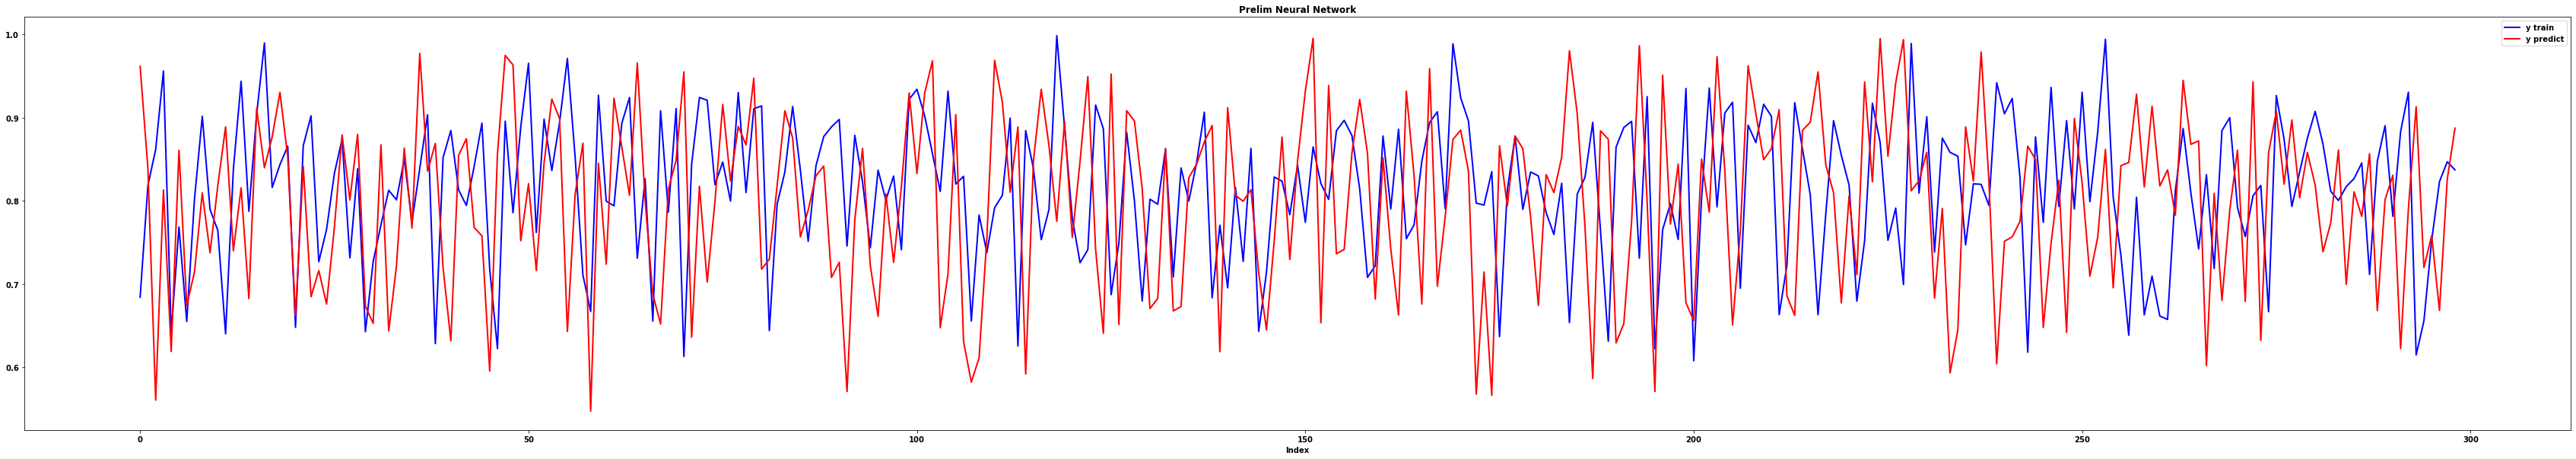

In [63]:
plt.plot( Y_train_torch, lw=2, color="blue", label="y train")
plt.plot( y_pred[0], lw=2, color="red", label="y predict")
plt.legend()
plt.title("Prelim Neural Network")
plt.xlabel("Index")
plt.rcParams["figure.figsize"] = (60,10)
plt.show()

In [64]:
df = pd.read_csv('load_per_country.csv', parse_dates=['DateTime'], index_col = ['DateTime'])
select = df[['PL','DE']]

select_2012 = select.loc['2012-01-01':'2015-12-31']

df = pd.read_csv('load_per_country.csv', parse_dates=['DateTime'], index_col = ['DateTime'])
gdp = pd.read_csv('gdp_per_country.csv', parse_dates=['DateTime'], index_col = ['DateTime'])
pop = pd.read_csv('population_per_country.csv', parse_dates=['DateTime'], index_col = ['DateTime'])
tmp =  pd.read_csv('tmp_per_country.csv', parse_dates=['DateTime'], index_col = ['DateTime'])

joined = df.join(gdp, on='DateTime', how='left', lsuffix = '', rsuffix = '_GDP', sort=False)

print(df.shape)
print(gdp.shape)

(87648, 40)
(10, 34)


In [65]:
joined = joined.join(pop, on='DateTime', how='left', lsuffix = '', rsuffix = '_POP', sort=False)
joined = joined.join(tmp, on='DateTime', how='left', lsuffix = '', rsuffix = '_TMP', sort=False)
joined = joined.replace(',','', regex=True)
joined_interpolate = joined.interpolate(method='ffill') # or method='index' works too
#pl = joined[['PL','PL_GDP','PL_POP', 'PL_TMP']]



In [66]:
country_datasets = []
country_list = ['PL', 'DE']

for country in country_list:
    country_dataset = joined_interpolate[[country, country + '_GDP', country+ '_POP', country+'_TMP']]
    country_datasets.append([country, country_dataset])

for each in country_datasets:
    name = each[0]
    dataset = each[1]

In [67]:
from sklearn.preprocessing import MinMaxScaler

nonan = dataset.dropna()
#nonan = nonan.groupby(pd.Grouper(level='DateTime', axis=0, freq='24H')).sum()
#print(nonan)

nonan = nonan.groupby(pd.Grouper(level='DateTime', axis=0, freq='M')).sum()
#print(nonan)
'''
# normalize
scaler = MinMaxScaler()
df_scaled = scaler.fit_transform(nonan.to_numpy())
df_scaled = pd.DataFrame(df_scaled, columns = ['DE_GDP', 'DE_POP', 'DE_TMP'])
'''
# normalize
nonan = nonan / nonan.max(axis=0) # works

x_trainDE, x_testDE, y_trainDE, y_testDE = train_test_split(nonan.iloc[:, :1].values, nonan['DE'].values,test_size=0.795)

X_train_torchDE = torch.tensor(x_trainDE).float()
Y_train_torchDE = torch.tensor(y_trainDE).float()
X_test_torchDE = torch.tensor(x_testDE).float()
Y_test_torchDE = torch.tensor(y_testDE).float()

In [68]:
print(X_train_torchDE)
print(Y_train_torchDE)
print(X_test_torchDE)
print(Y_test_torchDE)


print(X_train_torchDE.shape)
print(Y_train_torchDE.shape)

tensor([[0.8459],
        [0.8481],
        [0.8488],
        [0.8452],
        [0.9853],
        [0.9528],
        [0.8424],
        [0.9410],
        [0.8187],
        [0.8644],
        [0.9330],
        [0.8558],
        [0.8775],
        [0.8815],
        [0.9276],
        [1.0000],
        [0.7979],
        [0.8236],
        [0.8370],
        [0.9373],
        [0.8375],
        [0.8733],
        [0.8907],
        [0.9865]])
tensor([0.8459, 0.8481, 0.8488, 0.8452, 0.9853, 0.9528, 0.8424, 0.9410, 0.8187,
        0.8644, 0.9330, 0.8558, 0.8775, 0.8815, 0.9276, 1.0000, 0.7979, 0.8236,
        0.8370, 0.9373, 0.8375, 0.8733, 0.8907, 0.9865])
tensor([[0.8861],
        [0.9110],
        [0.8252],
        [0.8160],
        [0.7715],
        [0.9448],
        [0.8651],
        [0.8144],
        [0.9976],
        [0.7794],
        [0.8738],
        [0.8640],
        [0.8761],
        [0.8247],
        [0.8937],
        [0.8426],
        [0.8105],
        [0.9185],
        [0.8988],
        

In [74]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

nonan = dataset.dropna()
#nonan = nonan.groupby(pd.Grouper(level='DateTime', axis=0, freq='24H')).sum()
#print(nonan)

nonan = nonan.groupby(pd.Grouper(level='DateTime', axis=0, freq='M')).sum()
#print(nonan)
'''
# normalize
scaler = MinMaxScaler()
df_scaled = scaler.fit_transform(nonan.to_numpy())
df_scaled = pd.DataFrame(df_scaled, columns = ['DE_GDP', 'DE_POP', 'DE_TMP'])
'''
# normalize
nonan = nonan / nonan.max(axis=0) # works

x_trainDE, x_testDE, y_trainDE, y_testDE = train_test_split(nonan.iloc[:, :1].values, nonan['DE'].values,test_size=0.795)

X_train_torchDE = torch.tensor(x_trainDE).float()
Y_train_torchDE = torch.tensor(y_trainDE).float()
X_test_torchDE = torch.tensor(x_testDE).float()
Y_test_torchDE = torch.tensor(y_testDE).float()


nbus = 24
def train_loop(net,loss_fn,optimizer,X_train,Y_train):
    pred = net(X_train) # this calls the net.forward function, returning one prediction for each row of X.
    loss = loss_fn(pred, Y_train) # compute the loss associated with the predictions
    loss_traj.append(loss) # Record the loss at each iteration

    # Gradient descent
    optimizer.zero_grad() # Reset the gradients to zero
    loss.backward() # Compute the gradient of the loss with respect to each weight in the network
    optimizer.step() # Take a gradient step


class state_net(nn.Module): 
    def __init__(self):
        super(state_net, self).__init__()
        n_hidden = 24
        self.model = nn.Sequential(
            nn.Linear(nbus,n_hidden),
            nn.ReLU(),
            nn.Linear(n_hidden,n_hidden),
            nn.ReLU(),
            nn.Linear(n_hidden,n_hidden),
            nn.ReLU(),
            nn.Linear(n_hidden,nbus),
        )

    def forward(self, x): 
        return self.model(x)

loss_fn = nn.MSELoss()

net = state_net() # Create neural network

# Create an 'optimizer' object for training:
learning_rate = 1e-3
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)

loss_traj = []
    
T = 300
for t in range(T):
    train_loop(net,loss_fn,optimizer,X_train_torchDE.T,Y_train_torchDE)

Y_hat_trainDE = net(X_train_torchDE.T)
#Y_hat_test = net(X_test_torch.T)
print("Training error: ", (torch.linalg.norm(Y_hat_trainDE-Y_train_torchDE,ord='fro')**2/len(x_trainDE)).item())
#print("Test error: ", (torch.linalg.norm(Y_hat_test-Y_test_torch,ord='fro')**2/(M-n)).item())
loss_traj2 = []
for i in range(len(loss_traj)):
    #print(loss_traj[i])
    a = loss_traj[i].detach()
    loss_traj2.append(a)
plt.plot(loss_traj2)
#plt.plot(loss_traj)
plt.xlabel('Iteration number')
plt.ylabel('Training loss');

y_predDE = []
for i in range(len(Y_hat_trainDE)):
    #print(loss_traj[i])
    a = Y_hat_trainDE[i].detach()
    y_predDE.append(a)


RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x24 and 1162x1162)

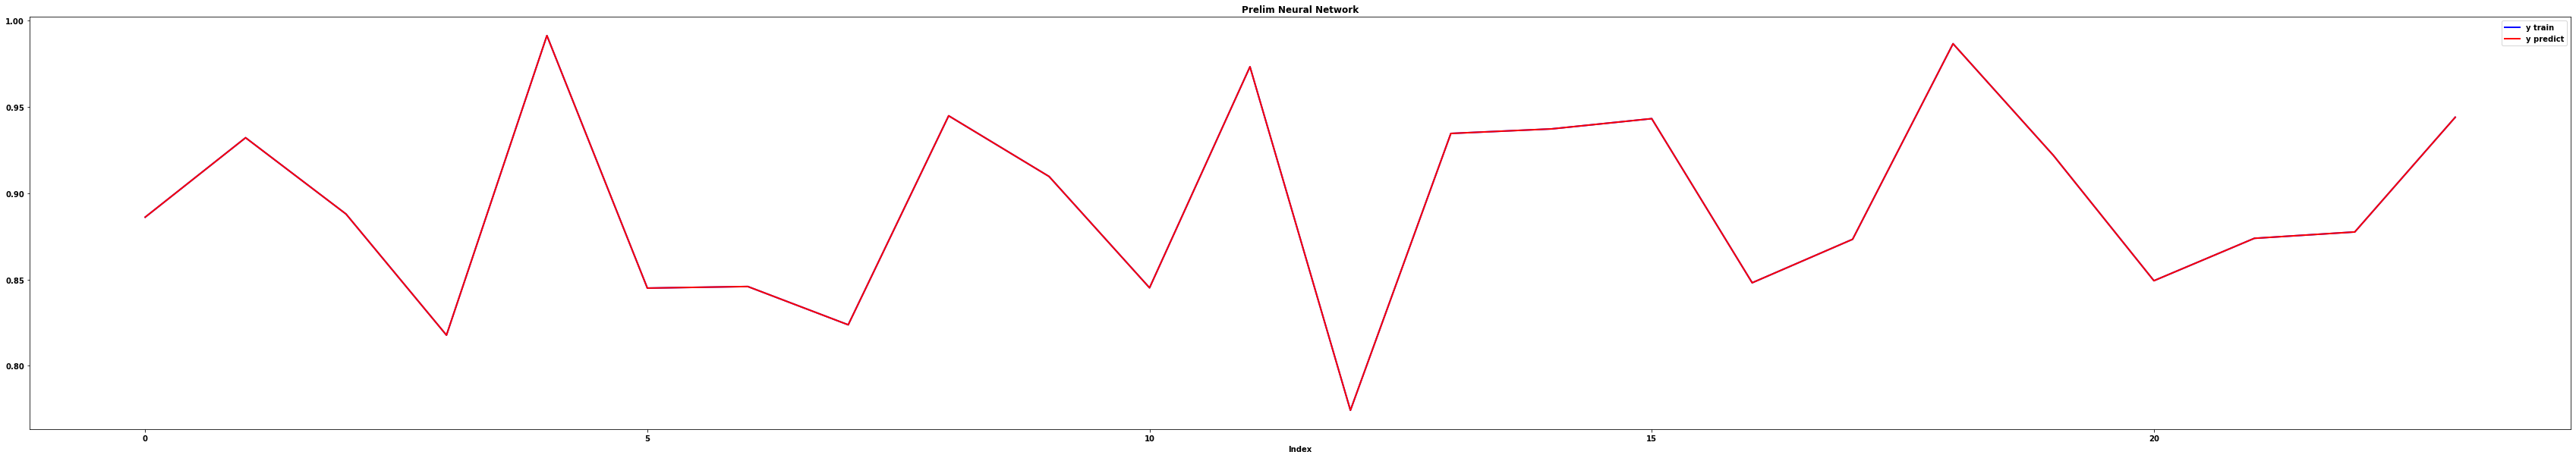

In [71]:
plt.plot( Y_train_torchDE, lw=2, color="blue", label="y train")
plt.plot( y_predDE[0], lw=2, color="red", label="y predict")
plt.legend()
plt.title("Prelim Neural Network")
plt.xlabel("Index")
plt.rcParams["figure.figsize"] = (60,10)
plt.show()

In [72]:
Y_hat_test = net(X_test_torch.T)

RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x1162 and 24x24)

In [ ]:
# TEST

In [ ]:
# TEST

Training error:  0.1746964454650879
Test error:  0.5229129791259766


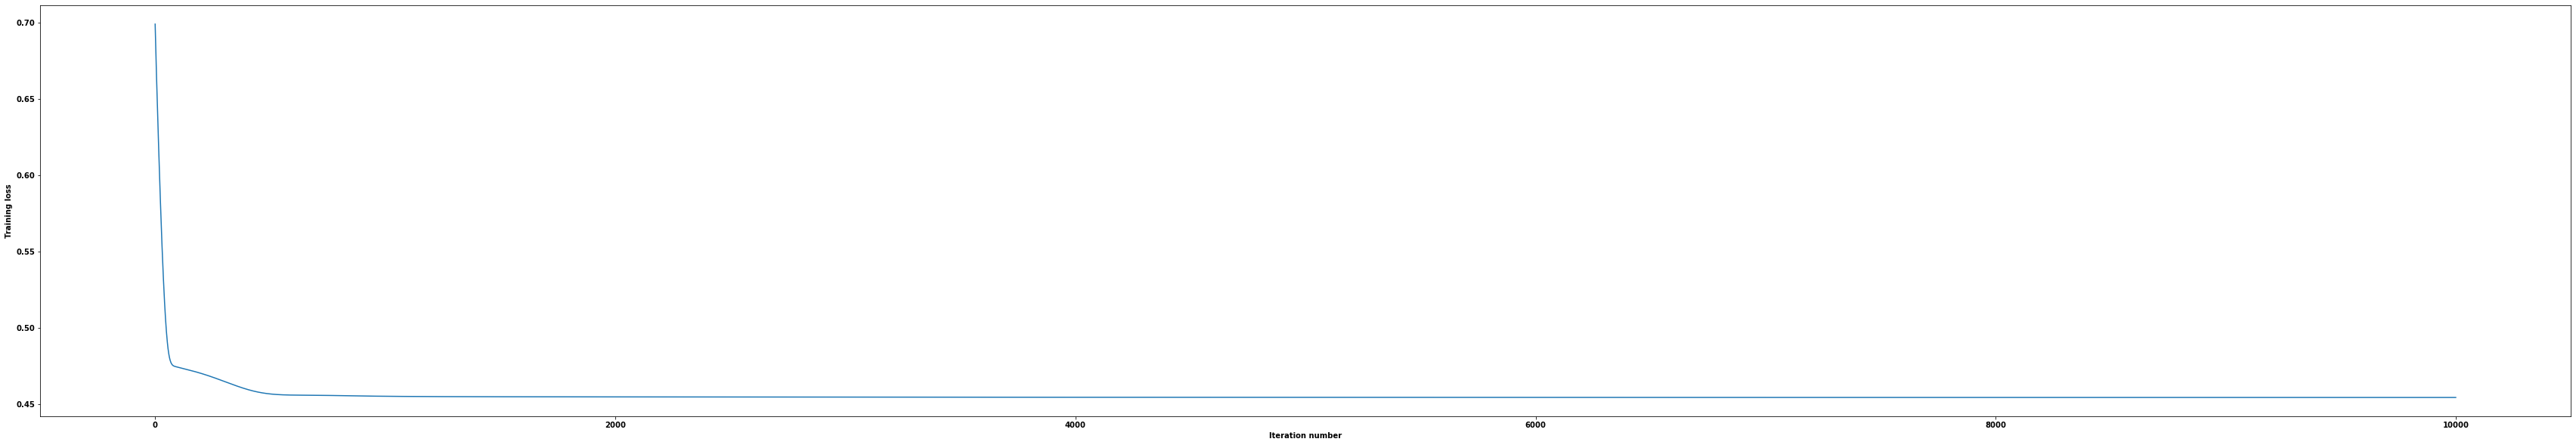

In [82]:
x_trainDE, x_testDE, y_trainDE, y_testDE = train_test_split(nonan.iloc[:, :1].values, nonan['DE'].values,test_size=0.795)

X_train_torchDE = torch.tensor(x_trainDE).float()
Y_train_torchDE = torch.tensor(y_trainDE).float()
X_test_torchDE = torch.tensor(x_testDE).float()
Y_test_torchDE = torch.tensor(y_testDE).float()

n_pmu = X_train_torchDE.shape[1]

# Neural network class:
class fault_net(nn.Module): 
    def __init__(self,n_hidden): # Passing the parameter n_hidden to the __init__ function allows us to customize the width of the network
        super(fault_net, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(n_pmu,n_hidden),
            nn.ReLU(),
            nn.Linear(n_hidden,n_hidden),
            nn.ReLU(),
            nn.Linear(n_hidden,1),
        )

    def forward(self, x): 
        return torch.sigmoid(self.model(x)) # Sigmoid clamps the output between 0 and 1 for binary classification
    
# Loss function for training:
loss_fn = nn.BCELoss() # Same loss function as for logistic regression

n_hidden = 24 # The width of each hidden layer in the network
net = fault_net(n_hidden) # Create neural network of width n_hidden

# Create an 'optimizer' object for training:
learning_rate = 1e-3
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)

loss_traj = []
    
T = 10000
for t in range(T):
    train_loop(net,loss_fn,optimizer,X_train_torch,Y_train_torch.unsqueeze(1))
    

Y_hat_trainDE = net(X_train_torchDE)
Y_hat_testDE = net(X_test_torchDE)
print("Training error: ", (torch.linalg.norm(Y_hat_trainDE-Y_train_torchDE,ord='fro')**2/len(x_trainDE)).item())
print("Test error: ", (torch.linalg.norm(Y_hat_testDE-Y_test_torchDE,ord='fro')**2/len(x_testDE)).item())
loss_traj2 = []
for i in range(len(loss_traj)):
    #print(loss_traj[i])
    a = loss_traj[i].detach()
    loss_traj2.append(a)
plt.plot(loss_traj2)
#plt.plot(loss_traj)
plt.xlabel('Iteration number')
plt.ylabel('Training loss');

y_predDE = []
for i in range(len(Y_hat_trainDE)):
    #print(loss_traj[i])
    a = Y_hat_trainDE[i].detach()
    y_predDE.append(a)


C:\Python\lib\site-packages\numpy\core\shape_base.py:65: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  ary = asanyarray(ary)
C:\Python\lib\site-packages\numpy\core\shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


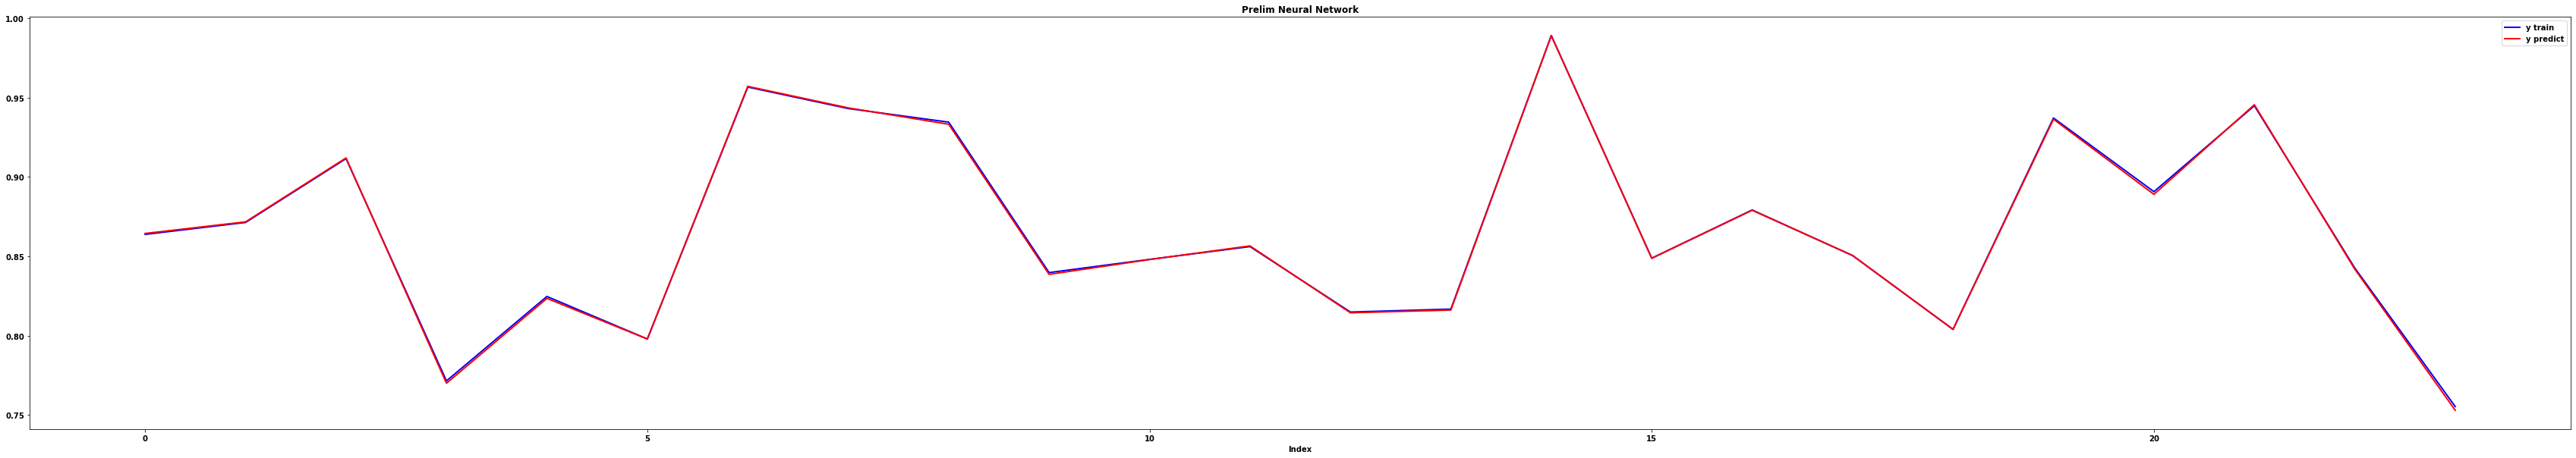

In [91]:
plt.plot( Y_train_torchDE, lw=2, color="blue", label="y train")
plt.plot( y_predDE, lw=2, color="red", label="y predict")
plt.legend()
plt.title("Prelim Neural Network")
plt.xlabel("Index")
plt.rcParams["figure.figsize"] = (60,10)
plt.show()

In [83]:
y_testDE = []
for i in range(len(Y_hat_testDE)):
    #print(loss_traj[i])
    a = Y_hat_testDE[i].detach()
    y_testDE.append(a)

C:\Python\lib\site-packages\numpy\core\shape_base.py:65: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  ary = asanyarray(ary)
C:\Python\lib\site-packages\numpy\core\shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


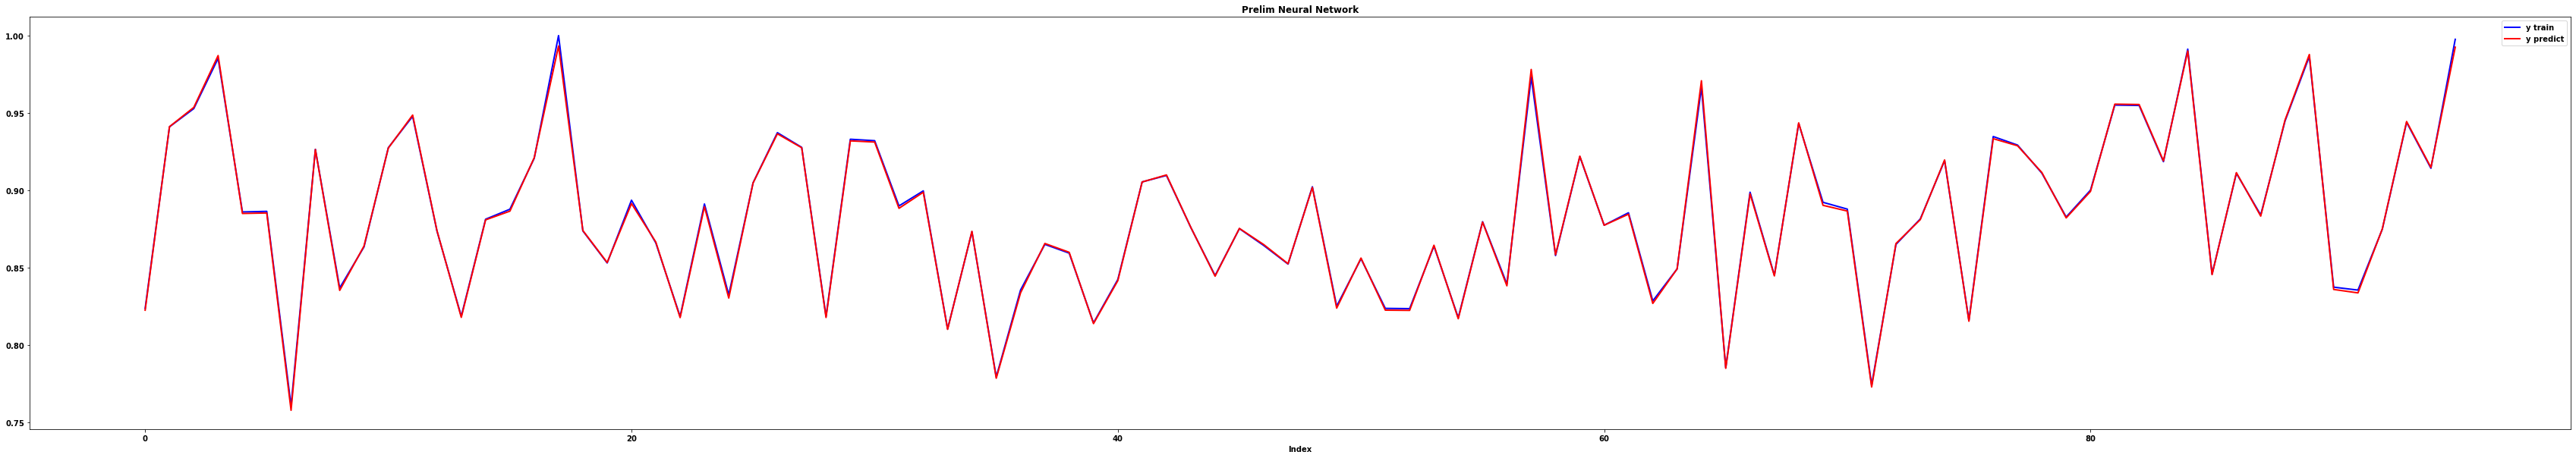

In [90]:
plt.plot( Y_test_torchDE, lw=2, color="blue", label="y train")
plt.plot( y_testDE, lw=2, color="red", label="y predict")
plt.legend()
plt.title("Prelim Neural Network")
plt.xlabel("Index")
plt.rcParams["figure.figsize"] = (60,10)
plt.show()